In [1]:
import os
import torch
# import numpy as np
import matplotlib.pyplot as plt
import torchio as tio
import torchvision
from trainer_lit import LitTrainer
from generator import GeneratorRRDB
from discriminator import Discriminator
from feature_extractor import FeatureExtractor
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from collections import OrderedDict
import argparse
from collections import namedtuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models.vgg as vgg
from dataset_tio import ImagePair, data_split, Normalize, calculate_overlap

print(os.getcwd())
torch.cuda.empty_cache()

/mnt/beta/djboonstoppel/Code


In [2]:
%load_ext autoreload
%autoreload 2

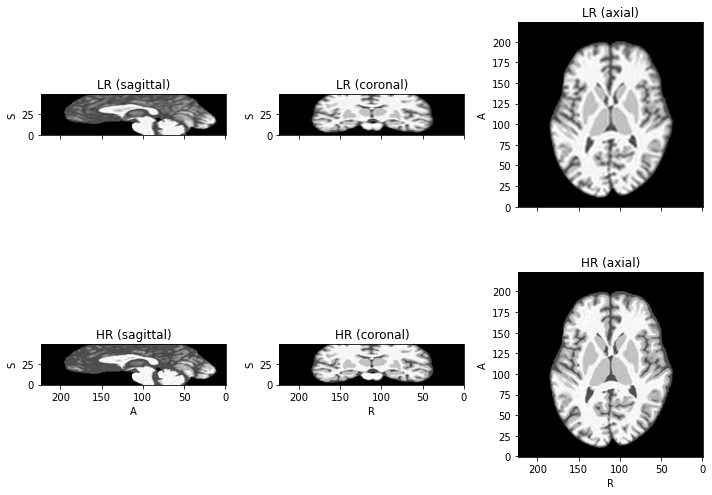

In [3]:
num = 100206
img = ImagePair(number=num, root_dir='data')
# img_slice = img.subject()['LR'].numpy()[0,:,:,25]
# plt.imshow(img_slice, cmap='gray')

img.subject().plot(figsize=(10,10))

In [4]:
train_subjects = data_split('training')
val_subjects = data_split('validation')

Load validation set	: 100%|███████████████| 30/30 [00:03<00:00,  7.76it/s]                                                             


In [5]:
std = 0.3548

training_transform = tio.Compose([
    Normalize(std=std),
    # tio.RandomNoise(p=0.5),
    # tio.RandomFlip(),
])

training_set = tio.SubjectsDataset(
    train_subjects, transform=training_transform)

val_set = tio.SubjectsDataset(
    val_subjects, transform=None)


In [6]:
batch_size = 32
training_batch_size = batch_size
validation_batch_size = batch_size

num_workers = 4
patch_size = (64,64)
ovl_perc = (.5, .5)
overlap, nr_patches = calculate_overlap(train_subjects[0]['LR'], patch_size, ovl_perc)
samples_per_volume = nr_patches

max_queue_length = samples_per_volume*10
sampler = tio.data.GridSampler(patch_size=(*patch_size,1), patch_overlap=overlap)#, padding_mode=0)

training_queue = tio.Queue(
    subjects_dataset=training_set,
    max_length=max_queue_length,
    samples_per_volume=samples_per_volume,
    sampler=sampler,
    num_workers=num_workers,
    shuffle_subjects=True,
    shuffle_patches=True,
)

val_queue = tio.Queue(
    subjects_dataset=val_set,
    max_length=max_queue_length,
    samples_per_volume=samples_per_volume,
    sampler=sampler,
    num_workers=num_workers,
    shuffle_subjects=False,
    shuffle_patches=False,
)

training_loader = torch.utils.data.DataLoader(
    training_queue, batch_size=training_batch_size)

val_loader = torch.utils.data.DataLoader(
    val_queue, batch_size=training_batch_size)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([20, 1, 64, 64])


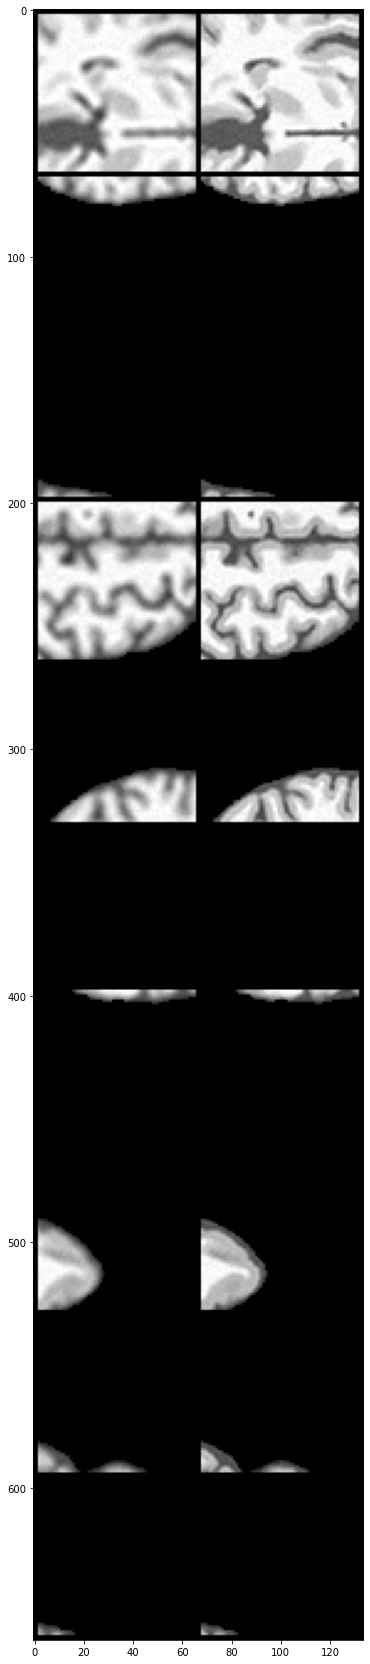

In [7]:
batch = next(iter(training_loader))

lr = batch['LR'][tio.DATA][:10]*std
hr = batch['HR'][tio.DATA][:10]*std

grid = torch.cat([torch.stack([a_row,b_row]) for a_row, b_row in zip(lr.squeeze(),hr.squeeze())]).unsqueeze(1)

print(grid.shape)
grid_img = torchvision.utils.make_grid(grid, nrow=2)

plt.figure(figsize=(10,30))
plt.imshow(grid_img.permute(1, 2, 0))

In [14]:
generator = GeneratorRRDB(channels=1, filters=64, num_res_blocks=1)
discriminator = Discriminator(input_shape=(1,64,64))
# feature_extractor = FeatureExtractor().to(device)

In [62]:
parser = argparse.ArgumentParser()
parser.add_argument('--generator', default=GeneratorRRDB(channels=1, filters=128, num_res_blocks=1))
parser.add_argument('--discriminator', default=Discriminator(input_shape=(1,65,65)))
opt = parser.parse_args("")

In [16]:
model = LitTrainer(netG=generator, netD=discriminator)
trainer = pl.Trainer(gpus= 2, max_epochs = 10)
trainer.fit(model, train_dataloaders=training_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2,3]

  | Name            | Type          | Params
--------------------------------------------------
0 | netG            | GeneratorRRDB | 445 K 
1 | netD            | Discriminator | 4.7 M 
2 | criterion_GAN   | GANLoss       | 0     
3 | criterion_pixel | L1Loss        | 0     
--------------------------------------------------
5.1 M     Trainable params
0         Non-trainable params
5.1 M     Total params
20.551    Total estimated model params size (MB)


lr =  0.0002


Training: 0it [00:00, ?it/s]